In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_without_weather.csv")
data.drop(['Month'], axis =1, inplace= True)
data.set_index("pickuptime", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

Time sequence 24hours(from 23 hours get 1 hours)

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 23

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [6]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 115) 26280 (26280,)
(26280, 23, 5) (26280,) (6517, 23, 5) (6517,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6517 samples
Epoch 1/100
 - 6s - loss: 0.0803 - val_loss: 0.0437
Epoch 2/100
 - 5s - loss: 0.0500 - val_loss: 0.0322
Epoch 3/100
 - 5s - loss: 0.0393 - val_loss: 0.0344
Epoch 4/100
 - 5s - loss: 0.0351 - val_loss: 0.0292
Epoch 5/100
 - 5s - loss: 0.0324 - val_loss: 0.0265
Epoch 6/100
 - 5s - loss: 0.0300 - val_loss: 0.0240
Epoch 7/100
 - 5s - loss: 0.0283 - val_loss: 0.0216
Epoch 8/100
 - 5s - loss: 0.0275 - val_loss: 0.0215
Epoch 9/100
 - 5s - loss: 0.0267 - val_loss: 0.0209
Epoch 10/100
 - 5s - loss: 0.0259 - val_loss: 0.0203
Epoch 11/100
 - 5s - loss: 0.0248 - val_loss: 0.0193
Epoch 12/100
 - 5s - loss: 0.0242 - val_loss: 0.0189
Epoch 13/100
 - 5s - loss: 0.0236 - val_loss: 0.0193
Epoch 14/100
 - 5s - loss: 0.0230 - val_loss: 0.0189
Epoch 15/100
 - 5s - loss: 0.0224 - val_loss: 0.0188
Epoch 16/100
 - 5s - loss: 0.0217 - val_loss: 0.0185
Epoch 17/100
 - 5s - loss: 0.0212 - val_loss: 0.0176
Epoch 18/100
 - 5s - loss: 0.0208 - val_loss: 0.0171
Epoch 

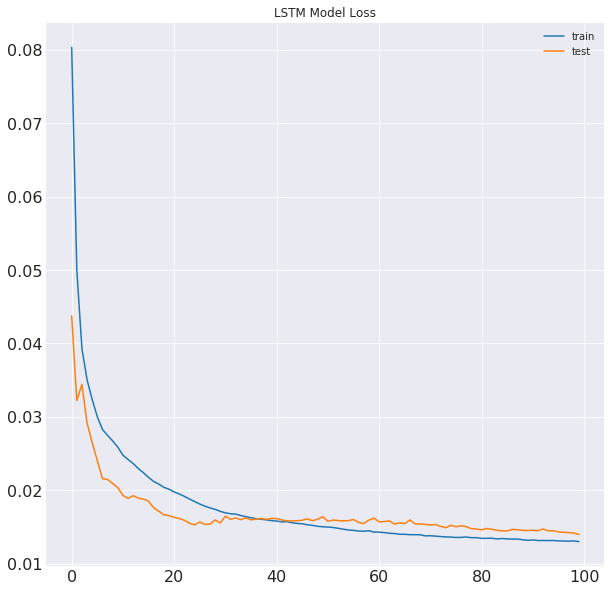

In [8]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [9]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 115:119], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 115:119], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9715324670846391
MAE:  784.1511
RMSE: 1110.6265686539289
mean absolute error percentage:  7.251535356044769


In [13]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 115:119], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 115:119], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9683806754697961
MAE:  1015.44415
RMSE: 1511.9983465599425
mean absolute error percentage:  6.435330957174301


Time sequence 12hours(from 11 hours get 1 hours)

In [14]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 11

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [15]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [16]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 55) 26280 (26280,)
(26280, 11, 5) (26280,) (6541, 11, 5) (6541,)


In [17]:
# design network
model = Sequential()
model.add(LSTM(12, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6541 samples
Epoch 1/100
 - 3s - loss: 0.1103 - val_loss: 0.0616
Epoch 2/100
 - 2s - loss: 0.0766 - val_loss: 0.0447
Epoch 3/100
 - 2s - loss: 0.0574 - val_loss: 0.0393
Epoch 4/100
 - 2s - loss: 0.0454 - val_loss: 0.0381
Epoch 5/100
 - 2s - loss: 0.0408 - val_loss: 0.0364
Epoch 6/100
 - 2s - loss: 0.0379 - val_loss: 0.0354
Epoch 7/100
 - 2s - loss: 0.0358 - val_loss: 0.0329
Epoch 8/100
 - 2s - loss: 0.0340 - val_loss: 0.0302
Epoch 9/100
 - 2s - loss: 0.0328 - val_loss: 0.0288
Epoch 10/100
 - 2s - loss: 0.0316 - val_loss: 0.0265
Epoch 11/100
 - 2s - loss: 0.0304 - val_loss: 0.0252
Epoch 12/100
 - 2s - loss: 0.0292 - val_loss: 0.0239
Epoch 13/100
 - 2s - loss: 0.0284 - val_loss: 0.0237
Epoch 14/100
 - 2s - loss: 0.0278 - val_loss: 0.0231
Epoch 15/100
 - 2s - loss: 0.0273 - val_loss: 0.0228
Epoch 16/100
 - 2s - loss: 0.0270 - val_loss: 0.0229
Epoch 17/100
 - 2s - loss: 0.0267 - val_loss: 0.0225
Epoch 18/100
 - 3s - loss: 0.0265 - val_loss: 0.0222
Epoch 

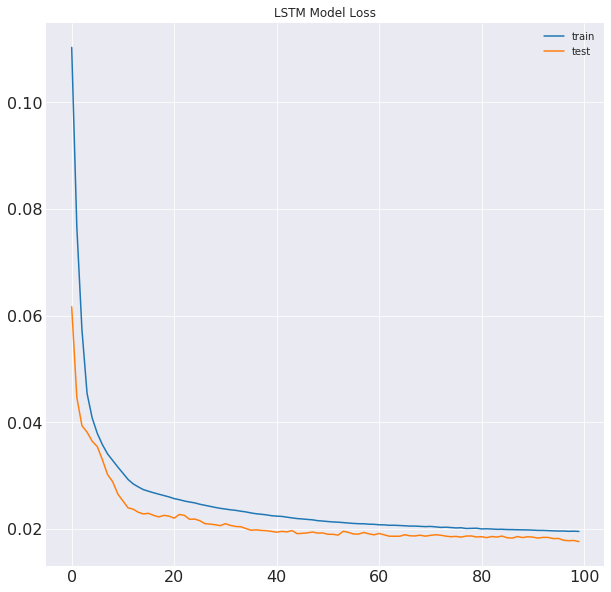

In [18]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [19]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast
inv_yhat = np.concatenate((test[:, 55:59], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 55:59], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9596283242926814
MAE:  986.7872
RMSE: 1321.8810460854638
mean absolute error percentage:  11.291171610355377


In [20]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 55:59], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 55:59], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9356199765137145
MAE:  1487.9613
RMSE: 2155.2504494837717
mean absolute error percentage:  10.640601068735123


Time sequence 48hours(from 47 hours get 1 hours)

In [21]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [22]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [23]:
# split into train and test sets  
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 235) 26280 (26280,)
(26280, 47, 5) (26280,) (6469, 47, 5) (6469,)


In [24]:
# design network
model = Sequential()
model.add(LSTM(48, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6469 samples
Epoch 1/100
 - 15s - loss: 0.0980 - val_loss: 0.0558
Epoch 2/100
 - 14s - loss: 0.0594 - val_loss: 0.0339
Epoch 3/100
 - 14s - loss: 0.0428 - val_loss: 0.0300
Epoch 4/100
 - 14s - loss: 0.0352 - val_loss: 0.0250
Epoch 5/100
 - 14s - loss: 0.0302 - val_loss: 0.0232
Epoch 6/100
 - 14s - loss: 0.0258 - val_loss: 0.0226
Epoch 7/100
 - 15s - loss: 0.0229 - val_loss: 0.0230
Epoch 8/100
 - 14s - loss: 0.0212 - val_loss: 0.0227
Epoch 9/100
 - 14s - loss: 0.0202 - val_loss: 0.0214
Epoch 10/100
 - 14s - loss: 0.0194 - val_loss: 0.0214
Epoch 11/100
 - 14s - loss: 0.0189 - val_loss: 0.0192
Epoch 12/100
 - 14s - loss: 0.0182 - val_loss: 0.0187
Epoch 13/100
 - 14s - loss: 0.0179 - val_loss: 0.0182
Epoch 14/100
 - 14s - loss: 0.0176 - val_loss: 0.0203
Epoch 15/100
 - 14s - loss: 0.0173 - val_loss: 0.0191
Epoch 16/100
 - 14s - loss: 0.0173 - val_loss: 0.0176
Epoch 17/100
 - 14s - loss: 0.0170 - val_loss: 0.0181
Epoch 18/100
 - 14s - loss: 0.0166 - val_l

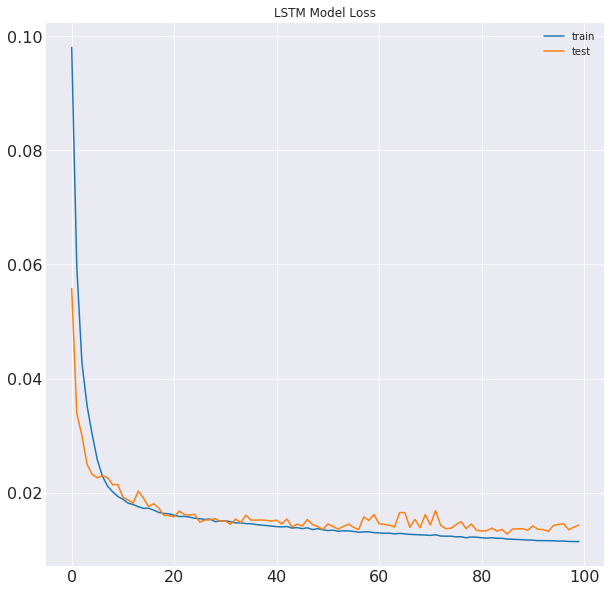

In [25]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [26]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9717544372685023
MAE:  806.31
RMSE: 1105.8792881684692
mean absolute error percentage:  7.781778275966644


In [27]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9734531634669388
MAE:  929.5647
RMSE: 1385.2296289785315
mean absolute error percentage:  6.406878679990768
